# Hyper Parameter Tuning

**Note**: This notebook is desinged to run on GPU runtime.

**[HPT-01]**

Install Flax and Optax

In [1]:
%%bash
pip install -q flax optax
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.0
jax                           0.3.17
jaxlib                        0.3.15+cuda11.cudnn805
optax                         0.1.3


**[HPT-02]**

Import modules.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame
from tensorflow.keras.datasets import mnist

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state

plt.rcParams.update({'font.size': 12})

**[HPT-03]**

Download the MNIST dataset and store into NumPy arrays.

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape([-1, 784]).astype('float32') / 255
test_images = test_images.reshape([-1, 784]).astype('float32') / 255
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

11501568/11490434 [==============================] - 0s 0us/step


**[HPT-04]**

Define a function to split the dataset into batches.

In [4]:
def create_batches(data, batch_size):
    num_batches, mod = divmod(len(data), batch_size)
    data_batched = np.array_split(data[:num_batches * batch_size], num_batches)
    if mod: # Last batch is smaller than batch_size
        data_batched.append(data[num_batches * batch_size:])
    data_batched = [jnp.asarray(x) for x in data_batched]
    return data_batched

**[HPT-05]**

Define a model for the softmax estimation with a single hidden layer.

In [5]:
class SingleLayerSoftmaxModel(nn.Module):
    num_nodes: int = 1024

    @nn.compact
    def __call__(self, x, get_logits=False):
        x = nn.Dense(features=self.num_nodes)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        if get_logits:
            return x
        x = nn.softmax(x)
        return x

**[HPT-06]**

Define a loss function as the categorical cross entoropy.

In [6]:
@jax.jit
def loss_fn(params, state, inputs, labels):
    logits = state.apply_fn({'params': params}, inputs, get_logits=True)
    loss = optax.softmax_cross_entropy(logits, labels).mean()
    acc = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(labels, -1))
    return loss, acc

**[MSL-07]**

Define a function to apply a single training step that returns a new training state.

In [7]:
@jax.jit
def train_step(state, inputs, labels):
    (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(
        state.params, state, inputs, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, acc

**[HPT-08]**

Define a function to apply the training steps for one epoch.

In [8]:
def train_epoch(state, input_batched, label_batched, eval=False):
    loss_history, acc_history = [], []
    for inputs, lables in zip(input_batched, label_batched):
        new_state, loss, acc = train_step(state, inputs, lables)
        if not eval:
            state = new_state
        loss_history.append(jax.device_get(loss).tolist())
        acc_history.append(jax.device_get(acc).tolist())
    return state, np.mean(loss_history), np.mean(acc_history)

**[HPT-09]**

Repeat applying the training steps for multiple epochs.

In [9]:
def fit(state, train_inputs, train_labels, test_inputs, test_labels,
        epochs, batch_size):

    train_inputs_batched = create_batches(train_inputs, batch_size)
    train_labels_batched = create_batches(train_labels, batch_size)
    test_inputs_batched = create_batches(test_inputs, batch_size)
    test_labels_batched = create_batches(test_labels, batch_size)

    loss_history_train, acc_history_train = [], []
    loss_history_test, acc_history_test = [], []

    for epoch in range(1, epochs+1):
        state, loss_train, acc_train = train_epoch(
            state, train_inputs_batched, train_labels_batched)
        loss_history_train.append(loss_train)
        acc_history_train.append(acc_train)

        _ , loss_test, acc_test = train_epoch(
            state, test_inputs_batched, test_labels_batched, eval=True)
        loss_history_test.append(loss_test)
        acc_history_test.append(acc_test)

        print ('Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f} / '.format(
            epoch, loss_train, acc_train), end='', flush=True)
        print ('Loss(Test): {:.4f}, Accuracy(Test): {:.4f}'.format(
            loss_test, acc_test), flush=True)
  
    history = {'loss_train': loss_history_train,
               'acc_train': acc_history_train,
               'loss_test': loss_history_test,
               'acc_test': acc_history_test}
  
    return state, history

**[HPT-10]**

Train models with different number of nodes, and record the reults.

In [10]:
%%time
meta_history = {}
for n in [128, 256, 512, 1024, 2048, 4096]:
    model = SingleLayerSoftmaxModel(num_nodes=n)
    key, key1 = random.split(random.PRNGKey(0))
    variables = model.init(key1, train_images[0:1])

    state = train_state.TrainState.create(
        apply_fn=model.apply,
        params=variables['params'],
        tx=optax.adam(learning_rate=0.001))

    print('==============')    
    print('num_nodes={}'.format(n))
    print('--------------')    
    state, history = fit(state, 
                     train_images, train_labels, test_images, test_labels,
                     epochs=16, batch_size=128)
    meta_history[n] = history

num_nodes=128
--------------
Epoch: 1, Loss: 0.3982, Accuracy: 0.8932 / Loss(Test): 0.2162, Accuracy(Test): 0.9371
Epoch: 2, Loss: 0.1862, Accuracy: 0.9465 / Loss(Test): 0.1532, Accuracy(Test): 0.9562
Epoch: 3, Loss: 0.1356, Accuracy: 0.9604 / Loss(Test): 0.1247, Accuracy(Test): 0.9627
Epoch: 4, Loss: 0.1057, Accuracy: 0.9696 / Loss(Test): 0.1093, Accuracy(Test): 0.9661
Epoch: 5, Loss: 0.0857, Accuracy: 0.9755 / Loss(Test): 0.0995, Accuracy(Test): 0.9691
Epoch: 6, Loss: 0.0711, Accuracy: 0.9799 / Loss(Test): 0.0930, Accuracy(Test): 0.9709
Epoch: 7, Loss: 0.0597, Accuracy: 0.9834 / Loss(Test): 0.0884, Accuracy(Test): 0.9729
Epoch: 8, Loss: 0.0503, Accuracy: 0.9859 / Loss(Test): 0.0856, Accuracy(Test): 0.9732
Epoch: 9, Loss: 0.0426, Accuracy: 0.9884 / Loss(Test): 0.0831, Accuracy(Test): 0.9743
Epoch: 10, Loss: 0.0361, Accuracy: 0.9906 / Loss(Test): 0.0816, Accuracy(Test): 0.9753
Epoch: 11, Loss: 0.0305, Accuracy: 0.9926 / Loss(Test): 0.0804, Accuracy(Test): 0.9754
Epoch: 12, Loss: 0.0259

**[HPT-11]**

Show maximum accuracy of each model against the testset.

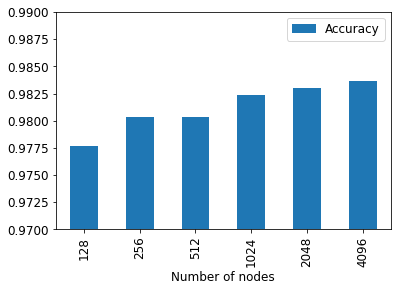

In [11]:
df = DataFrame({n: [np.max(meta_history[n]['acc_test'])]
                for n in meta_history.keys()}).T
df.columns = ['Accuracy']
ax = df.plot(kind='bar', figsize=(6, 4))
ax.set_xlabel('Number of nodes')
_ = ax.set_ylim([0.97, 0.99])